# CNN-lytical Assignment-3
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import random

import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
import os

def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1_IHICOfAsT7x63VBBuN1WMh4bDqtUThp/view?usp=sharing) shared for this assignment here.

In [9]:
# load the data set

df = pd.read_pickle('/content/drive/MyDrive/CNN-lytical/Week 4/train_cifar.pkl')
df['X'] = torch.from_numpy(df['X'])/255
df['y'] = torch.from_numpy(df['y'])

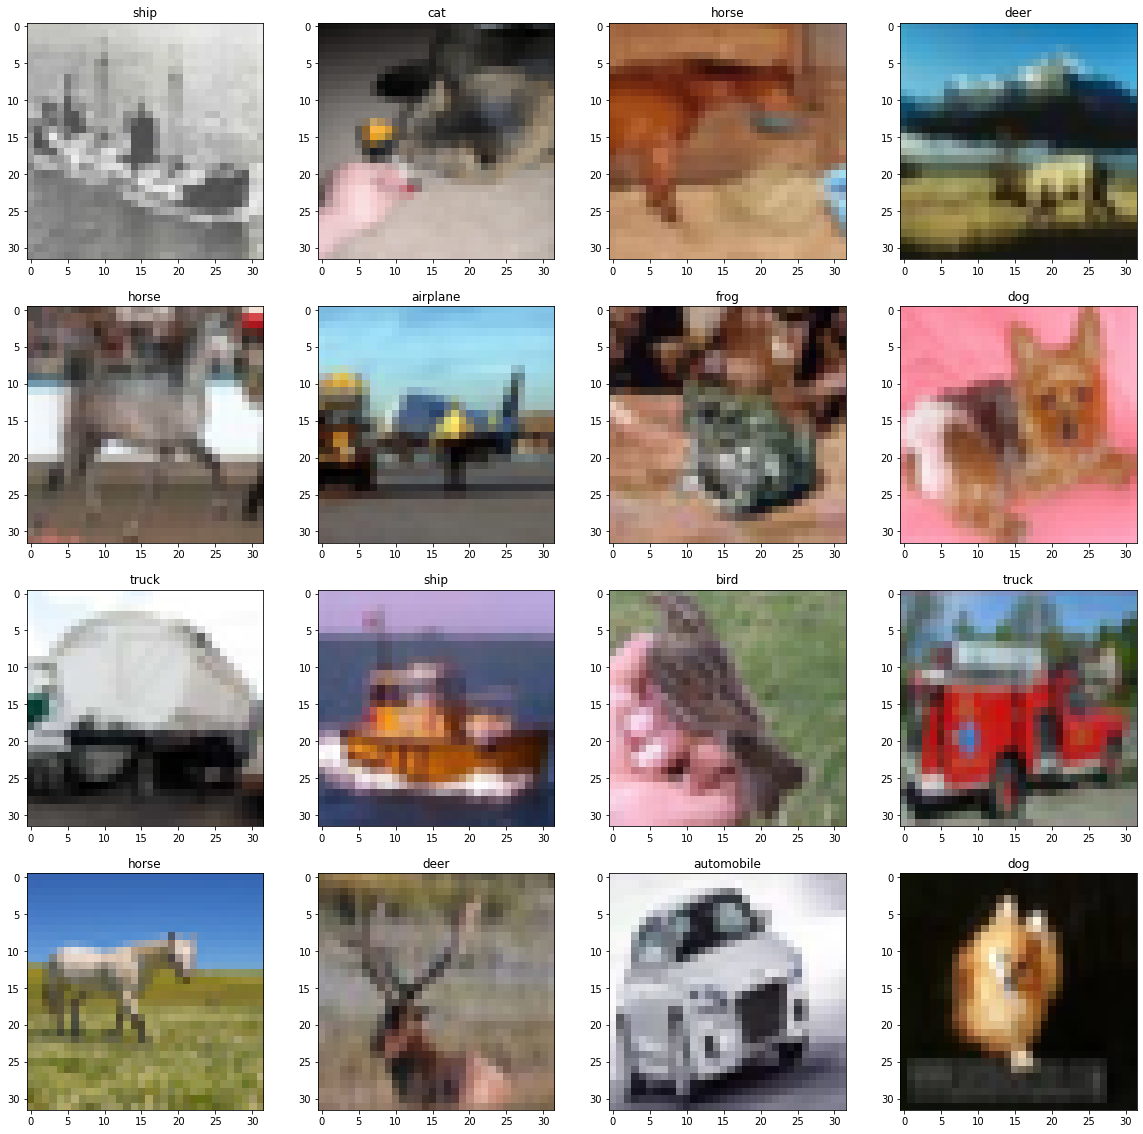

In [10]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels

classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

f, axarr = plt.subplots(4,4, figsize=(20,20))

i = 0
j = 0
for t in range(16):
  x = random.randint(0,50000)
  if j>3:
    j = 0
    i += 1

  axarr[i, j].imshow(df['X'][x]);
  axarr[i, j].set_title(classes[df['y'][x].item()])

  j+=1

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

You will have to perform normalization, augmentation on the dataset here itself, have a look at [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html).

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and labels. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [11]:
# define your dataset class

from torch.utils.data import TensorDataset
data = TensorDataset(df['X'], df['y'])

from torch.utils.data import random_split
train_ds, val_ds = random_split(data, [45000,5000])

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [12]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()                  
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)    
    self.pool = nn.MaxPool2d(2, 2)      
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(256*4*4,1024)
    self.fc2 = nn.Linear(1024,512)
    self.fc3 = nn.Linear(512,10)

    self.batchnorm1 = nn.BatchNorm2d(64)
    self.batchnorm2 = nn.BatchNorm2d(128)
    self.batchnorm3 = nn.BatchNorm2d(256)

  def forward(self, x):
    x = self.batchnorm1(self.pool(F.relu(self.conv2(F.relu(self.conv1(x))))))
    x = self.batchnorm2(self.pool(F.relu(self.conv4(F.relu(self.conv3(x))))))
    x = self.batchnorm3(self.pool(F.relu(self.conv6(F.relu(self.conv5(x))))))
    x = x.reshape(-1, 256*4*4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [22]:
def predict(model, batch_set):
  prediction = []
  with torch.no_grad():
    for xb, _ in batch_set:
      xb = xb.to(device)
      preds = []
      output = model(xb.reshape(-1,3,32,32))
      for i in output:
        preds.append(torch.argmax(i))
      prediction.append(preds)
  
  return torch.tensor(prediction[:-1])

In [14]:
def accuracy(model, batch_set):  
  correct = 0
  total = 0

  with torch.no_grad():
    for xb, yb in batch_set:
      xb = xb.to(device)
      yb = yb.to(device)
      yb = yb.reshape(-1)
      output = model(xb.reshape(-1,3,32,32))
      for idxs, i in enumerate(output):
        if torch.argmax(i) == yb[idxs]:
          correct += 1
        total += 1
  
  return (100*correct/total)

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [15]:
def train(model, epochs, optimizer, loss_fn, train_loader, display_step=None):
  best_accuracy = 0

  for epoch in range(epochs):
  
    model.train()
    for xb, yb in train_loader:

      xb = xb.to(device)
      yb = yb.to(device)

      output = model(xb.reshape(-1,3,32,32))
      loss = loss_fn(output,yb.reshape(-1))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
  
    model.eval()
    val_accuracy = accuracy(model, val_loader)
    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      torch.save(model, 'ass_2.pt')
    if display_step == True:
      train_accuracy = accuracy(model, train_loader)
      print("Epoch:",epoch+1,"Training Accuracy:",train_accuracy,"Validation Accuracy:",val_accuracy)

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [17]:
model = ConvNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)

epochs=30

train(model, epochs, optimizer, loss_fn, train_loader, display_step=True)

Epoch: 1 Training Accuracy: 39.62888888888889 Validation Accuracy: 39.24
Epoch: 2 Training Accuracy: 44.48222222222222 Validation Accuracy: 42.92
Epoch: 3 Training Accuracy: 47.437777777777775 Validation Accuracy: 44.82
Epoch: 4 Training Accuracy: 53.85111111111111 Validation Accuracy: 51.92
Epoch: 5 Training Accuracy: 56.202222222222225 Validation Accuracy: 52.5
Epoch: 6 Training Accuracy: 56.053333333333335 Validation Accuracy: 52.84
Epoch: 7 Training Accuracy: 57.72 Validation Accuracy: 53.2
Epoch: 8 Training Accuracy: 61.413333333333334 Validation Accuracy: 56.06
Epoch: 9 Training Accuracy: 55.593333333333334 Validation Accuracy: 50.64
Epoch: 10 Training Accuracy: 65.47555555555556 Validation Accuracy: 59.54
Epoch: 11 Training Accuracy: 66.68888888888888 Validation Accuracy: 58.58
Epoch: 12 Training Accuracy: 65.32222222222222 Validation Accuracy: 56.1
Epoch: 13 Training Accuracy: 67.42888888888889 Validation Accuracy: 57.14
Epoch: 14 Training Accuracy: 72.87555555555555 Validation

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [18]:
final_model = torch.load('/content/ass_2.pt')

In [23]:
print(predict(final_model, val_loader))

tensor([[3, 3, 7,  ..., 8, 6, 2],
        [0, 8, 7,  ..., 4, 7, 6],
        [8, 9, 2,  ..., 5, 4, 7],
        ...,
        [8, 3, 7,  ..., 4, 7, 7],
        [2, 3, 4,  ..., 3, 4, 1],
        [0, 7, 4,  ..., 8, 5, 6]])


In [25]:
print(accuracy(final_model, val_loader))

61.74


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_2.pt``` model-weights file to the repository.

In [26]:
from google.colab import files
files.download('ass_2.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [27]:
# load the model, use predict function
model_load = torch.load('/content/ass_2.pt')
predict(final_model, val_loader)

tensor([[3, 3, 7,  ..., 8, 6, 2],
        [0, 8, 7,  ..., 4, 7, 6],
        [8, 9, 2,  ..., 5, 4, 7],
        ...,
        [8, 3, 7,  ..., 4, 7, 7],
        [2, 3, 4,  ..., 3, 4, 1],
        [0, 7, 4,  ..., 8, 5, 6]])